# Dogs and People Detection (Thermal images) with YOLOv5 - Transfer Learning

This activity is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on dogs and people thermal images. 

To speed up data preparation, we will use Roboflow's clean data management tools.  This technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

Ref: [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this activity

In this activity, we will walk through the steps required to train YOLOv5 on our thermal images. We use a [public Thermal dogs and people dataset](https://public.roboflow.com/object-detection/thermal-dogs-and-people), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download YOLOv5 object detection datasets and meta data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference






#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)
%cd yolov5


# Then, we can take a look at our training environment provided to us for free from Google Colab.
import torch
from IPython.display import Image, clear_output  # to display images
#from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# Download Correctly Formatted Dataset 

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

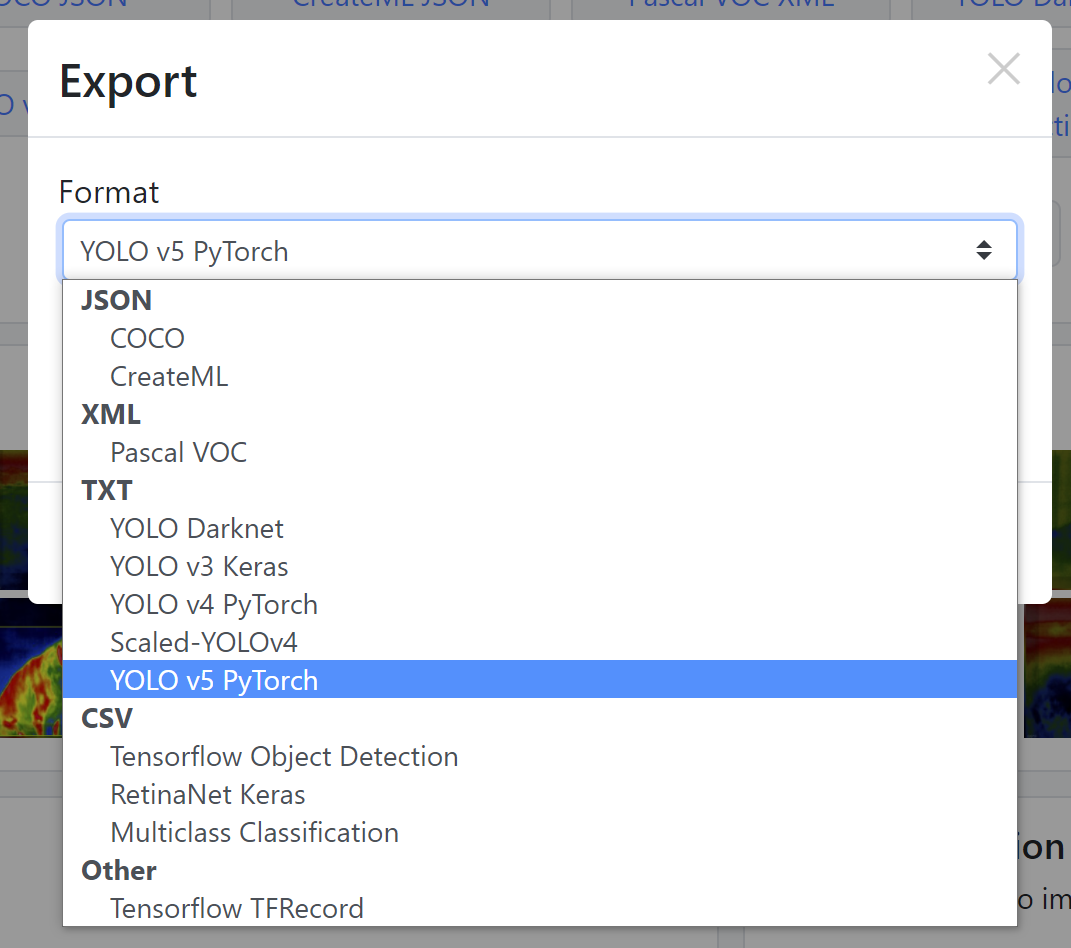



**Quick Note on Labeling Tools**

If you have unlabeled images, you will first need to label them. For free open source labeling tools, you can try [Roboflow Annotate](https://docs.roboflow.com/annotate) or the following guides on [getting started with LabelImg](https://blog.roboflow.com/getting-started-with-labelimg-for-labeling-object-detection-data/) or [getting started with CVAT](https://blog.roboflow.com/getting-started-with-cvat/) annotation tools. Try labeling ~50 images to get a feel of labeling. To improve your model's performance later, you will want to label more.



In [ ]:
# Export code snippet and paste here
%cd /content
!curl -L "https://public.roboflow.com/ds/LL3OKIx9sc?key=AMYvloI1fQ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

The export creates a YOLOv5 .yaml file called `data.yaml` specifying the location of a YOLOv5 `images` folder, a YOLOv5 `labels` folder, and information on our custom classes.

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

# Define Model Configuration and Architecture

Next we write a model configuration file for our custom object detector. For this activity, we chose the smallest, fastest base model of YOLOv5. You have the option to pick from other YOLOv5 models including:

* YOLOv5s
* YOLOv5m
* YOLOv5l
* YOLOv5x

You can also edit the structure of the network in this step, though rarely will you need to do this. Here is the YOLOv5 model configuration file, which we term `custom_yolov5s.yaml`:




```
nc: 3
depth_multiple: 0.33
width_multiple: 0.50

anchors:
  - [10,13, 16,30, 33,23] 
  - [30,61, 62,45, 59,119]
  - [116,90, 156,198, 373,326] 

backbone:
  [[-1, 1, Focus, [64, 3]],
   [-1, 1, Conv, [128, 3, 2]],
   [-1, 3, Bottleneck, [128]],
   [-1, 1, Conv, [256, 3, 2]],
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]], 
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 6, BottleneckCSP, [1024]],
  ]

head:
  [[-1, 3, BottleneckCSP, [1024, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],
   [-2, 1, nn.Upsample, [None, 2, "nearest"]],
   [[-1, 6], 1, Concat, [1]],
   [-1, 1, Conv, [512, 1, 1]],
   [-1, 3, BottleneckCSP, [512, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],
   [-2, 1, nn.Upsample, [None, 2, "nearest"]],
   [[-1, 4], 1, Concat, [1]],
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 3, BottleneckCSP, [256, False]],
   [-1, 1, nn.Conv2d, [na * (nc + 5), 1, 1, 0]],

   [[], 1, Detect, [nc, anchors]],
  ]
```



We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))


In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!

With our `data.yaml` and `custom_yolov5s.yaml` files ready to go we are ready to train!

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 50 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

During training, you want to be watching the mAP@0.5 to see how your detector is performing - see this post on [breaking down mAP](https://blog.roboflow.com/what-is-mean-average-precision-object-detection/).

# Evaluate Custom YOLOv5 Detector Performance

Now that we have completed training, we can evaluate how well the training procedure performed by looking at the validation metrics. The training script will drop tensorboard logs in runs. We visualize those here:

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

In [ ]:
!pwd

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='runs/train/yolov5s_results/train_batch1.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

Now we take our trained model and make inference on test images. After training has completed model weights will save in `weights/`. For inference we invoke those weights along with a `conf` specifying model confidence (higher confidence required makes less predictions), and a inference `source`. `source` can accept a directory of images, individual images, video files, and also a device's webcam port. For source, I have moved our test/*jpg to `test/images/`.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

In [ ]:
%ls runs/train/yolov5s_results/weights

In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights  runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../test/images

Finally, we visualize our inference on ALL test images.  This will look much better with longer training above

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DataFolder = "/content/drive/MyDrive/SDAAI/data"
ThermalFolder = DataFolder + "/LU04_Thermal"

In [ ]:
import os
thermal_model = ThermalFolder+ "/model"
if not os.path.exists(thermal_model):
  os.makedirs(thermal_model)

%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt $thermal_model

Copy output images for reference

In [ ]:
thermal_output = ThermalFolder+ "/output"
if not os.path.exists(thermal_output):
  os.makedirs(thermal_output)

%cp /content/yolov5/runs/detect/exp/*.* $thermal_output

In [ ]:
%ls $ThermalFolder -lR

## Congrats!

Hope you enjoyed this!
